In [1]:
from IPython.display import display, HTML
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import numpy as np
import sqlite3
import cv2
import os

In [2]:
MASKED_IMAGES_DIR = "masked_images"
BACKEND_DIR = "backend"
IMAGES_DIR = "images"

DB_FILE = "db.sqlite"

PASSWORD_CHARACTERS = 10 + 52 + 32
""" = (0-9) + (a-z,A-Z) + Special Characters """

IMAGE_SIZE = 256
NUMBER_OF_IMAGES = 2

MIN_R = 3
MAX_R = 30

SAME_POINT_TOLERANCE = 10

In [3]:
print(F"Plaintext character size: {PASSWORD_CHARACTERS}")

Plaintext character size: 94


In [4]:
image_masks = {}
image_attributes = set()
for image in os.listdir(os.path.join(os.curdir, MASKED_IMAGES_DIR)):
    name = image.split(".")[0]
    image_masks[name] = np.squeeze(cv2.imread(os.path.join(os.curdir, MASKED_IMAGES_DIR, image), cv2.IMREAD_UNCHANGED)[:, :, 3])
    image_masks[name] = np.where(image_masks[name] < 255, 1, 0)
    image_attributes.add(name.split("_")[-1])

In [5]:
results = sqlite3.connect(DB_FILE)

In [6]:
users = pd.read_sql_query("SELECT * FROM user;", results)
passwords = pd.read_sql_query("SELECT * FROM passwords;", results)
attempts = pd.read_sql_query("SELECT * FROM attempts;", results)

In [7]:
def extract_images(row):
    if not pd.isnull(row["password"]):
        points = row["password"].split(",")
        images = list(set([point.split()[0] for point in points]))
        return images + [np.nan] * (2 - len(images))
    else:
        return [row["password"], row["password"]]

In [8]:
def extract_types(row):
    if not pd.isnull(row["image1"]) and not pd.isnull(row["image2"]):
        image1_has_digit = any(map(str.isdigit, row["image1"]))
        image2_has_digit = any(map(str.isdigit, row["image2"]))
        used_natural = image1_has_digit or image2_has_digit
        used_geometric = image1_has_digit is False or image2_has_digit is False
        if used_geometric and used_natural:
            return "Both"
        return "Natural" if used_natural else "Geometric"
    elif not pd.isnull(row["image1"]):
        image1_has_digit = any(map(str.isdigit, row["image1"]))
        return "Natural" if image1_has_digit else "Geometric"
    else:
        return np.nan

In [9]:
def check_points(row):
    if not pd.isnull(row["password"]):
        attributes = set()
        points = row["password"].split(",")
        points = [tuple(point.split()) for point in points]

        for point in points:
            image_name = point[0].split(".")[0]
            for key, value in [(mask_name, image_mask) for mask_name, image_mask in image_masks.items() if image_name in mask_name]:
                if value[int(point[1]), int(point[2])] > 0:
                    attributes.add(key.split("_")[-1])
        
        return ", ".join(sorted(attributes)) if attributes else np.nan
    else:
        return np.nan

In [10]:
def unique_points(row):
    if not pd.isnull(row["password"]):
        points = row["password"].split(",")
        points = [tuple(point.split()) for point in points]

        points_dict = {}
        for point in points:
            image_name = point[0]
            if image_name in points_dict:
                if not any((abs(int(point[1]) - existing[0]) + abs(int(point[2]) - existing[1])) < SAME_POINT_TOLERANCE for existing in points_dict[image_name]):
                    points_dict[image_name].append((int(point[1]), int(point[2])))

            else:
                points_dict[image_name] = [(int(point[1]), int(point[2]))]

        unique_points = 0
        for key in points_dict.keys():
            unique_points += len(points_dict[key])

        return unique_points

    else:
        return 0

In [11]:
full_df = pd.merge(users, attempts, on="id", how="left")
full_df = pd.merge(full_df, passwords, on=["id", "r"], how="left").sort_values(by=["username", "r"]).reset_index(drop=True)
full_df["password_length"] = full_df.apply(lambda row: row["password"] if pd.isnull(row["password"]) else len(row["password"].split(",")), axis=1)
full_df[["image1", "image2"]] = full_df.apply(lambda row: extract_images(row), axis=1, result_type="expand")
full_df["image_types"] = full_df.apply(lambda row: extract_types(row), axis=1)
full_df["natural_characteristics"] = full_df.apply(lambda row: check_points(row), axis=1)
full_df["unique_points"] = full_df.apply(lambda row: unique_points(row), axis=1)

In [12]:
print(F"Number of particiants: {len(full_df['id'].unique().tolist())}")

Number of particiants: 19


In [13]:
print(F"Number of passwords: {len(full_df['password'].dropna().tolist())}")

Number of passwords: 23


In [14]:
display(HTML(full_df.to_html()))

,id,username,r,attempts,successes,password,password_length,image1,image2,image_types,natural_characteristics,unique_points
0,e17eb5fda55044b89e048aac4eb18e3a,Alex,10,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0
1,fc2848119b284402b643ea38af52c1f4,Dassa01,5,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0
2,fc2848119b284402b643ea38af52c1f4,Dassa01,10,9,0,NaN,NaN,NaN,NaN,NaN,NaN,0
3,4595b9f10c654b639a83f8a9e838e692,ZachF,15,2,0,NaN,NaN,NaN,NaN,NaN,NaN,0
4,dfa3e1d80e724c99a82675ec32f17b26,ZachF2,10,1,0,NaN,NaN,NaN,NaN,NaN,NaN,0
5,1e6bd3ef31874fd48359a206d2d3a737,Zachf,5,8,0,NaN,NaN,NaN,NaN,NaN,NaN,0
6,1e6bd3ef31874fd48359a206d2d3a737,Zachf,15,3,1,"reknep.jpg 31 27, reknep.jpg 30 24, reknep.jpg 24 26, reknep.jpg 152 28, reknep.jpg 150 26, reknep.jpg 150 27",6.0,reknep.jpg,NaN,Geometric,NaN,2
7,08a98157812b411b876001eedf684cb6,a,10,1,1,"pmvyje.jpg 128 118, pmvyje.jpg 128 118, jyrskv.jpg 132 128, jyrskv.jpg 132 128, pmvyje.jpg 62 193, pmvyje.jpg 192 190",6.0,pmvyje.jpg,jyrskv.jpg,Geometric,NaN,4
8,08a98157812b411b876001eedf684cb6,a,20,1,1,"93011.jpg 206 30, 93011.jpg 104 82, 93011.jpg 166 126, 124431.jpg 156 52, 124431.jpg 76 104, 124431.jpg 101 143",6.0,93011.jpg,124431.jpg,Natural,background,6
9,a0617c4bf7bf4a48b6a05ccf210416f4,ajakob,15,4,1,"jyrskv.jpg 41 2, jyrskv.jpg 129 132, 664322.jpg 44 230, 664322.jpg 134 230, 664322.jpg 228 56, 664322.jpg 248 65",6.0,jyrskv.jpg,664322.jpg,Both,"background, mouth",6


In [15]:
not_finished = full_df.loc[~full_df.duplicated("username", keep=False), "id"].unique()
print(F"Percent of people that did not complete the survey: {len(not_finished)}/{len(full_df['username'].unique().tolist())} = {len(not_finished) / len(full_df['username'].unique().tolist())}")

Percent of people that did not complete the survey: 5/19 = 0.2631578947368421


In [16]:
r_grouped = full_df.groupby("r")

,Sample Size,Success Rate,Average Attemps,Passwords Made
r,,,,
3,2.0,0.076923,6.500000,1.0
5,7.0,0.160000,3.571429,4.0
10,7.0,0.250000,2.285714,4.0
15,5.0,0.266667,3.000000,4.0
20,8.0,0.470588,2.125000,8.0
30,4.0,0.100000,5.000000,2.0


<Figure size 432x288 with 0 Axes>

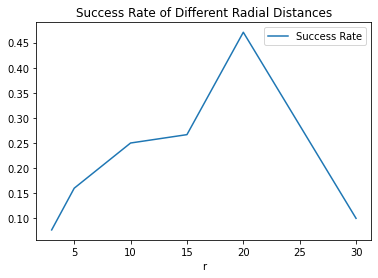

In [17]:
average_success = r_grouped.apply(lambda df: pd.Series({"Sample Size": len(df.index),
                                                        "Success Rate": df["successes"].sum() / df["attempts"].sum(),
                                                        "Average Attemps": df["attempts"].mean(),
                                                        "Passwords Made": df["successes"].sum()}))
display(HTML(average_success.to_html()))
plt.figure()
average_success.plot(y="Success Rate", use_index=True)
plt.title("Success Rate of Different Radial Distances")
plt.show()

In [18]:
made_password_r_group = full_df.loc[full_df["successes"] != 0].groupby("r")

,Sample Size,Success Rate,Average Attempts,Passwords Made
r,,,,
3,1.0,0.333333,3.000,1.0
5,4.0,0.444444,2.250,4.0
10,4.0,1.000000,1.000,4.0
15,4.0,0.307692,3.250,4.0
20,8.0,0.470588,2.125,8.0
30,2.0,1.000000,1.000,2.0


<Figure size 432x288 with 0 Axes>

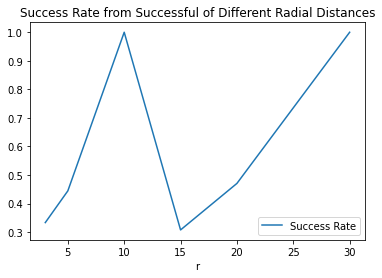

In [19]:
average_success_of_successful = made_password_r_group.apply(lambda df: pd.Series({"Sample Size": len(df.index),
                                                        "Success Rate": df["successes"].sum() / df["attempts"].sum(),
                                                        "Average Attempts": df["attempts"].mean(),
                                                        "Passwords Made": df["successes"].sum()}))
display(HTML(average_success_of_successful.to_html()))
plt.figure()
average_success_of_successful.plot(y="Success Rate", use_index=True)
plt.title("Success Rate from Successful of Different Radial Distances")
plt.show()

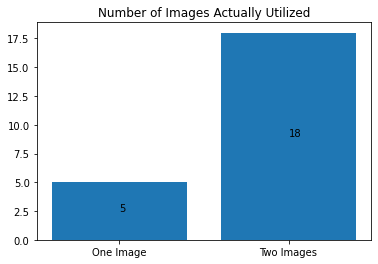

In [20]:
one_image = len(full_df.loc[(~pd.isnull(full_df["image1"])) & (pd.isnull(full_df["image2"]))].index)
two_images = len(full_df.loc[(~pd.isnull(full_df["image1"])) & (~pd.isnull(full_df["image2"]))].index)

plt.figure()
plt.bar(["One Image", "Two Images"], [one_image, two_images])
plt.title("Number of Images Actually Utilized")
plt.text(0, one_image / 2, F"{one_image}")
plt.text(1, two_images / 2, F"{two_images}")
plt.show()

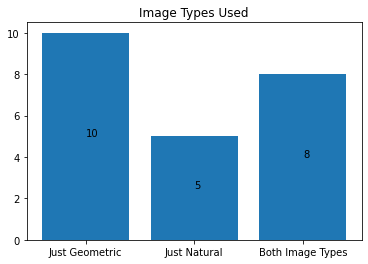

In [21]:
just_geometric = len(full_df.loc[full_df["image_types"] == "Geometric"].index)
just_natural = len(full_df.loc[full_df["image_types"] == "Natural"].index)
both_types = len(full_df.loc[full_df["image_types"] == "Both"].index)

plt.figure()
plt.bar(["Just Geometric", "Just Natural", "Both Image Types"], [just_geometric, just_natural, both_types])
plt.title("Image Types Used")
plt.text(0, just_geometric / 2, F"{just_geometric}")
plt.text(1, just_natural / 2, F"{just_natural}")
plt.text(2, both_types / 2, F"{both_types}")
plt.show()

In [22]:
group_r_image_type = full_df.groupby(by=["r", "image_types"])

In [23]:
average_success_by_type = group_r_image_type.apply(lambda df: pd.Series({"Sample Size": len(df.index),
                                                        "Success Rate": df["successes"].sum() / df["attempts"].sum(),
                                                        "Average Attempts": df["attempts"].mean(),
                                                        "Passwords Made": df["successes"].sum()}))

print(average_success_by_type.sort_index())

                Sample Size  Success Rate  Average Attempts  Passwords Made
r  image_types                                                             
3  Geometric            1.0      0.333333          3.000000             1.0
5  Both                 2.0      0.285714          3.500000             2.0
   Geometric            2.0      1.000000          1.000000             2.0
10 Geometric            2.0      1.000000          1.000000             2.0
   Natural              2.0      1.000000          1.000000             2.0
15 Both                 2.0      0.400000          2.500000             2.0
   Geometric            2.0      0.250000          4.000000             2.0
20 Both                 3.0      0.375000          2.666667             3.0
   Geometric            2.0      1.000000          1.000000             2.0
   Natural              3.0      0.428571          2.333333             3.0
30 Both                 1.0      1.000000          1.000000             1.0
   Geometric

In [24]:
masked_names = [name for name in image_masks.keys()]

In [25]:
for background_mask in [mask for mask in masked_names if "background" in mask]:
    image_name = background_mask.split("_")[0]
    for image_mask in [mask for mask in masked_names if image_name in mask and not "background" in mask]:
        image_masks[background_mask] = np.where(image_masks[image_mask] > 0, 0, image_masks[background_mask])

In [26]:
print(image_masks["83990_nose"])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [27]:
image_attribute_counts = {}
for attribute in image_attributes:
    image_attribute_counts[attribute.title()] = len(full_df.loc[full_df["natural_characteristics"].str.contains(attribute, na=False, regex=False)].index)

image_attribute_counts["Total Natural Image Passwords"] = len(full_df.loc[(full_df["image_types"] == "Both") | (full_df["image_types"] == "Natural")].index)

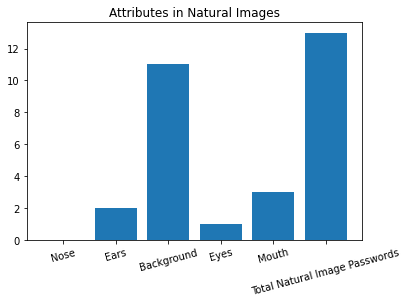

In [28]:
plt.figure()
plt.bar(image_attribute_counts.keys(), image_attribute_counts.values())
plt.title("Attributes in Natural Images")
plt.xticks(rotation=15)
plt.show()

In [29]:
length_group = full_df.groupby("password_length")

,Sample Size,Average Unique Points,Standard Deviation of Unique Points,Max Unique Points,Min Unique Points
password_length,,,,,
6.0,18.0,5.0,1.533930,6.0,2.0
7.0,1.0,2.0,NaN,2.0,2.0
10.0,2.0,10.0,0.000000,10.0,10.0
12.0,2.0,11.5,0.707107,12.0,11.0


<Figure size 432x288 with 0 Axes>

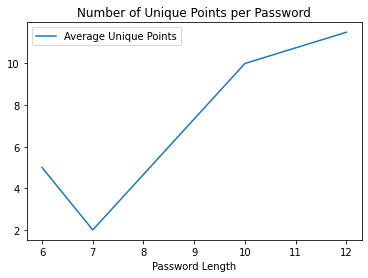

In [30]:
average_unique_points = length_group.apply(lambda df: pd.Series({"Sample Size": len(df.index),
                                                        "Average Unique Points": df["unique_points"].mean(),
                                                        "Standard Deviation of Unique Points": df["unique_points"].std(),
                                                        "Max Unique Points": df["unique_points"].max(),
                                                        "Min Unique Points": df["unique_points"].min()}))

display(HTML(average_unique_points.sort_index().to_html()))
plt.figure()
average_unique_points.plot(y="Average Unique Points", use_index=True)
plt.title("Number of Unique Points per Password")
plt.xlabel("Password Length")
plt.ylabel("Unique Points in Password")
plt.show()